Credits to the Experts (Please like their kernels)<br>
Ashish Gupta: [24+ top lgbm models outputs](https://www.kaggle.com/roydatascience/lgmodels)<br>
Konstantin: [ieee-internal-blend](https://www.kaggle.com/kyakovlev/ieee-internal-blend)<br>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Stacking Approach using GMEAN

In [2]:
LABELS = ["isFraud"]
all_files = glob.glob("../input/lgmodels/*.csv")
scores = np.zeros(len(all_files))
for i in range(len(all_files)):
    scores[i] = float('.'+all_files[i].split(".")[3])

In [3]:
top = scores.argsort()[::-1]
for i, f in enumerate(top):
    print(i,scores[f],all_files[f])

0 0.9485 ../input/lgmodels/submission-.9485.csv
1 0.948 ../input/lgmodels/submission-.9480.csv
2 0.9475 ../input/lgmodels/submission-0.9475.csv
3 0.9474 ../input/lgmodels/submission-.9474.csv
4 0.9473 ../input/lgmodels/submission-.9473.csv
5 0.9471 ../input/lgmodels/submission-.9471.csv
6 0.9469 ../input/lgmodels/submission-.9469.csv
7 0.9468 ../input/lgmodels/submission-0.9468.csv
8 0.9467 ../input/lgmodels/submission-0.9467.csv
9 0.9466 ../input/lgmodels/submission-.9466.csv
10 0.9466 ../input/lgmodels/submission-0.9466.csv
11 0.9463 ../input/lgmodels/submission-.9463.csv
12 0.946 ../input/lgmodels/submission-.9460.csv
13 0.9459 ../input/lgmodels/submission-.9459.csv
14 0.9457 ../input/lgmodels/submission-.9457.csv
15 0.9454 ../input/lgmodels/submission-.9454.csv
16 0.9452 ../input/lgmodels/submission-.9452.csv
17 0.9452 ../input/lgmodels/submission_.9452.csv
18 0.9451 ../input/lgmodels/submission-.9451.csv
19 0.9449 ../input/lgmodels/submission-.9449.csv
20 0.9442 ../input/lgmodels/

In [4]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in top]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols

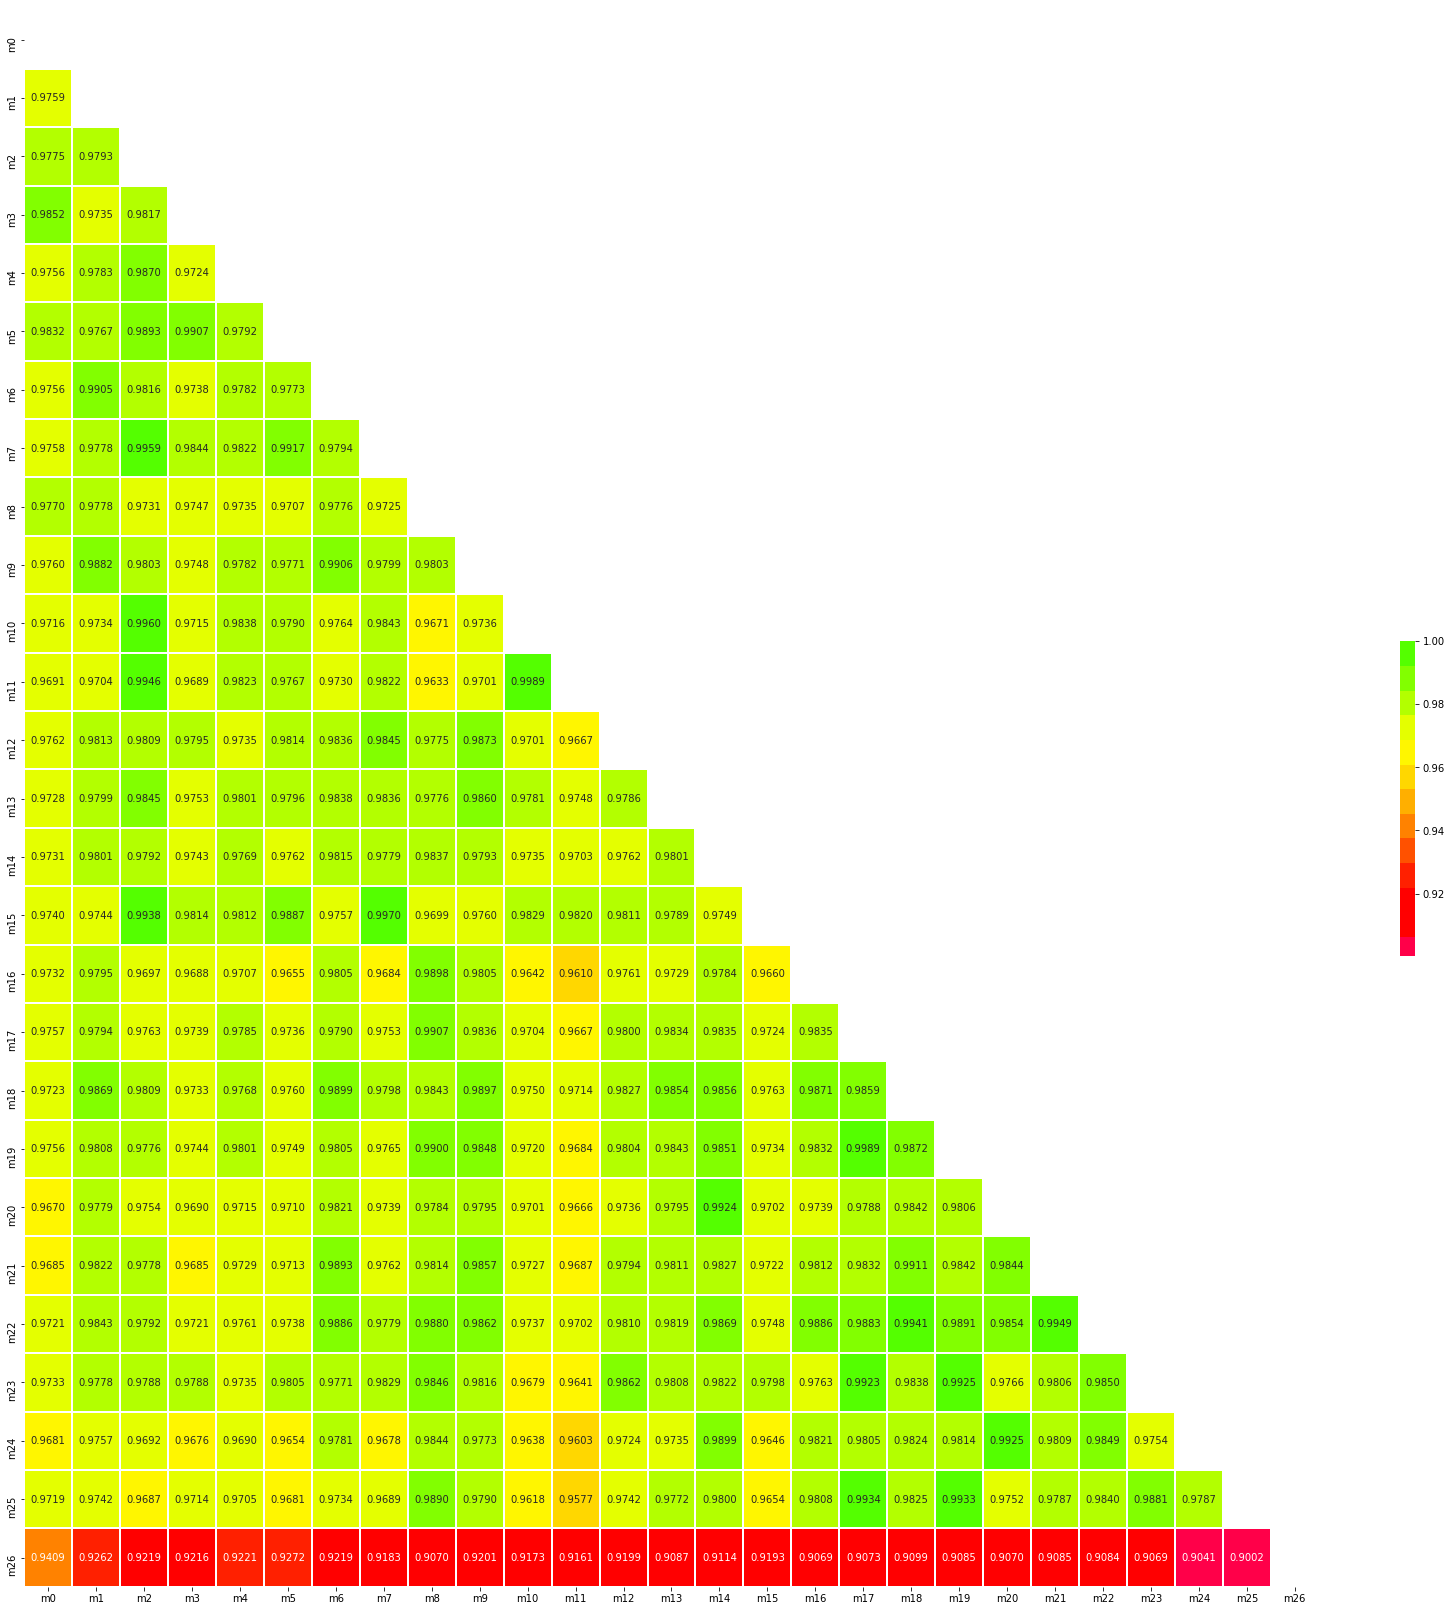

In [5]:
# check correlation
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})

# Select models with low average correlation

In [6]:
mean_corr = corr.mean()
mean_corr = mean_corr.sort_values(ascending=True)
mean_corr = mean_corr[:6]
mean_corr

m26    0.918057
m11    0.970907
m10    0.973675
m24    0.973702
m0     0.973965
m3     0.974125
dtype: float64

# GMEAN of models with low average correlation

In [7]:
m_gmean1 = 0
for n in mean_corr.index:
    m_gmean1 += np.log(concat_sub[n])
m_gmean1 = np.exp(m_gmean1/len(mean_corr))

# Weighted GMEAN by inverse correlation

In [8]:
rank = np.tril(corr.values,-1)
rank[rank<0.92] = 1
m = (rank>0).sum() - (rank>0.97).sum()
m_gmean2, s = 0, 0
for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/m
    m_gmean2 += w*(np.log(concat_sub.iloc[:,mx[0]])+np.log(concat_sub.iloc[:,mx[1]]))/2
    s += w
    rank[mx] = 1
m_gmean2 = np.exp(m_gmean2/s)

# Top Blends weighted by score
Based on: https://www.kaggle.com/muhakabartay/0-8518-what-proper-weights-give-ieee-int-blend

In [9]:
top_mean = 0
s = 0
for n in [0,1,3,7,26]:
    top_mean += concat_sub.iloc[:,n]*scores[top[n]]
    s += scores[top[n]]
top_mean /= s

# GMEAN Final Stacking

In [10]:
m_gmean = np.exp(0.3*np.log(m_gmean1) + 0.2*np.log(m_gmean2) + 0.5*np.log(top_mean))
describe(m_gmean)

DescribeResult(nobs=506691, minmax=(0.00011447051406740683, 1.002243888340239), mean=0.02577874246497794, variance=0.012977876281497967, skewness=7.029804175405381, kurtosis=51.1017311957154)

In [11]:
concat_sub['isFraud'] = m_gmean
concat_sub[['isFraud']].to_csv('stack_gmean.csv')